## A/B test results analysis.

It is necessary to analyze the results of an experiment that was conducted **from 2023-03-02 to 2023-03-08 inclusive. Groups '2' and '1' were used for the experiment.**

In experimental group '2', one of the new algorithms for recommending posts was used, group '1' was used as a control.

The main hypothesis is that the new algorithm in the 2nd group will lead to an increase in CTR metric.

### The purpose of the study

- To choose an analysis method and compare CTR between two groups

- To compare the data with these test

- To work out a recommendation whether it is reasonable to roll out a new algorithm to all new users or not.

### Data overview

- It is defined that providing A/B test from '2023-03-02' to '2023-03-08' would be enough to gain statistically significant results
- Experimental groups '2' and '1' were chosen for this test

### Research plan

Data about users' activity is presented in Clickhouse. Therefore, it is needed to set the connection and write a query to import data. 

It is known that quality of data is good and it doesn't require preprocessing before analysis.

Thus, the study will go in several stages:

- Data import
- Visual data analysis
- Chosing analysis method

Firstly we need to import all necessary libraries:

In [16]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

After that it is needed to set up a connection to Clickhouse:

In [17]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database': 'simulator_20230320',
              'user':'student',
              'password':'dpo_python_2020'
             }

And write a relevant query

In [18]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-03-02' and '2023-03-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

After that request for data can be executed

In [19]:
df = ph.read_clickhouse(q, connection=connection)

Let's study the distribution visually:

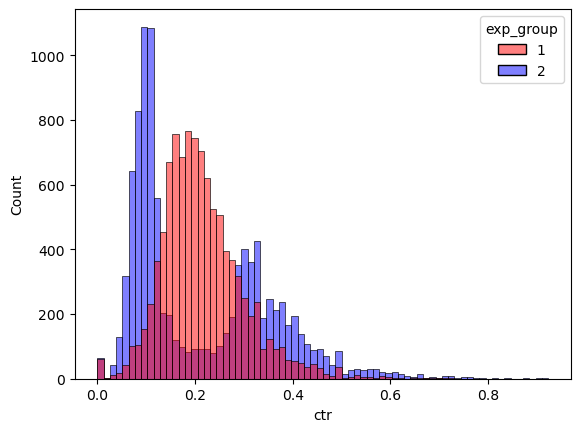

In [20]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

It can be seen that the test sample has a bimodal distribution of the CTR indicator, which means that the results of the t-test may be incorrect. Instead, the Mann-Whitney test and Median bootstrap will be conducted.

The reason for the appearance of such a distribution may be a factor that may have made a selection according to some criterion for 2 subsamples with different audiences (etc.: gender / operating system / source). In this case, one of the subsamples might not like the recommendations presented by the new system.

In [21]:
mwhitney = stats.mannwhitneyu(df[df['exp_group']==1].ctr, df[df['exp_group']==2].ctr)

In [22]:
mwhitney

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

We see that the p-value according to the results of the Mann-Whitney test is below the significance level (assumed at 0.05), which means that the probability of obtaining such or even more significant difference between the two samples is very small, which allows us to reject the null hypothesis about the absence of differences.

### Poisson Bootstrap

In [23]:
def poisson_bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000) -> tuple:

    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

# Control
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
# Test
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()


ctr_control, ctr_test = poisson_bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

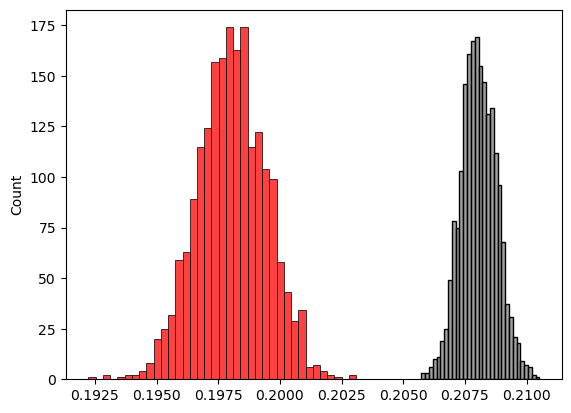

In [24]:
sns.histplot(data=ctr_control, color='grey', kde=False)
sns.histplot(data=ctr_test,    color='r',    kde=False)

<AxesSubplot:ylabel='Count'>

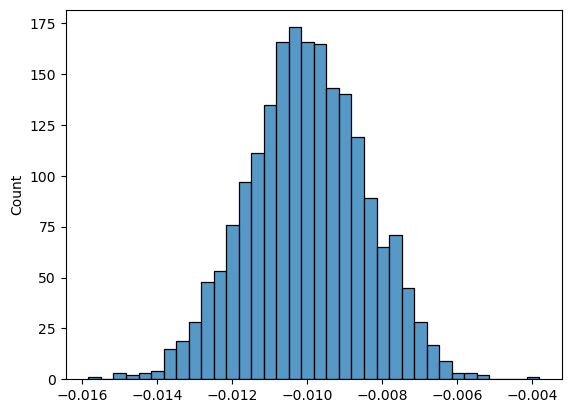

In [25]:
sns.histplot(ctr_test - ctr_control, kde=False)

### Bucket conversion

In [26]:
q = """
select
    exp_group, 
    bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr_9
from (
    select
        exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    from {db}.feed_actions 
    where 
        toDate(time) >= '2023-03-02'
    and toDate(time) <= '2023-03-09'
    and exp_group in (1,2)
    group by
        exp_group, 
        bucket, 
        user_id
)
group by 
    exp_group, 
    bucket
"""
df = ph.read_clickhouse(q, connection=connection)

In [28]:
# mean values comparance
bucket_ttest_mean = stats.ttest_ind(
                    df[df.exp_group == 1].bucket_ctr, 
                    df[df.exp_group == 2].bucket_ctr, 
                    equal_var = False)
bucket_mw_mean = stats.mannwhitneyu(
                    df[df.exp_group == 1].bucket_ctr, 
                    df[df.exp_group == 2].bucket_ctr, 
                    alternative = 'two-sided')


# quantiles comparance
bucket_ttest_quantile = stats.ttest_ind(
                            df[df.exp_group == 1].ctr_9, 
                            df[df.exp_group == 2].ctr_9, 
                            equal_var = False)
bucket_mw_quantile    = stats.mannwhitneyu(
                            df[df.exp_group == 1].ctr_9, 
                            df[df.exp_group == 2].ctr_9, 
                            alternative = 'two-sided')


print("Mean values comparance")
print("T-test (pvalue):", bucket_ttest_mean.pvalue)
print("U-test (pvalue):", bucket_mw_mean.pvalue)
print()
print("quantiles comparance")
print("T-test (pvalue):", bucket_ttest_quantile.pvalue)
print("U-test (pvalue):", bucket_mw_quantile.pvalue)

Mean values comparance
T-test (pvalue): 1.4596015329482579e-06
U-test (pvalue): 7.045566667668902e-07

quantiles comparance
T-test (pvalue): 5.566224101504785e-39
U-test (pvalue): 6.807696809632693e-18


### The result of the study

The new algorithm has an impact on the target indicator, but due to the separation of users on an indefinite basis, it can be seen that the value of the target indicator for the resulting subgroups is different. The average user CTR for both subgroups decreased relative to the control group.
Thus, it is necessary to figure out what caused the segregation of users and eliminate it. Until then, the new algorithm cannot be applied.